#MoveWise

#### We created a dynamic pricing optimization model using CVXPY to assign passengers to drivers, minimizing cost and distance while maximizing revenue. The model incorporates historical ride costs, simulated distances, and potential revenue for each passenger-driver pair. Constraints ensure each passenger is assigned to exactly one driver, and each driver can serve at most one passenger. The optimization problem is solved using the SCIPY solver. Finally, the optimized assignments and details for each passenger-driver pair are printed, including cost, distance, and revenue information.

### Importing data

In [68]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [151]:
import cvxpy as cp
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Location weights (assigning weights for different areas)
location_weights = {
    "Andheri": 0.1, "Bandra": 0.1, "Churchgate": 0.05, "Colaba": 0.05, "Dadar": 0.1,
    "Goregaon": 0.05, "Kalyan": 0.05, "Lonavala": 0.02, "Malad": 0.08, "Mulund": 0.05,
    "Navi Mumbai": 0.07, "Panvel": 0.03, "Powai": 0.06, "Thane": 0.08, "Virar": 0.03,
    "Borivali": 0.05, "Kurla": 0.06, "Vashi": 0.04, "Jogeshwari": 0.03, "Versova": 0.04
}

# Normalize weights to ensure they sum to 1
normalized_weights = {k: v / sum(location_weights.values()) for k, v in location_weights.items()}

# Coordinates for each location (latitude, longitude)
location_coordinates = {
    "Andheri": (19.1349, 72.8410),
    "Bandra": (19.0598, 72.8258),
    "Churchgate": (18.9372, 72.8258),
    "Colaba": (18.9351, 72.8194),
    "Dadar": (19.0185, 72.8340),
    "Goregaon": (19.1508, 72.8560),
    "Kalyan": (19.2463, 73.1350),
    "Lonavala": (18.7499, 73.4133),
    "Malad": (19.1894, 72.8471),
    "Mulund": (19.1907, 72.9467),
    "Navi Mumbai": (19.0330, 73.0297),
    "Panvel": (18.9864, 73.1107),
    "Powai": (19.1245, 72.8996),
    "Thane": (19.2183, 72.9781),
    "Virar": (19.3060, 72.8279),
    "Borivali": (19.2393, 72.8505),
    "Kurla": (19.0620, 72.8698),
    "Vashi": (19.0760, 72.9860),
    "Jogeshwari": (19.1476, 72.8423),
    "Versova": (19.1261, 72.8347)
}

# Number of rides to generate
n_rides = 20

# Generate random start and end locations based on normalized weights
start_locations = np.random.choice(
    list(normalized_weights.keys()), size=n_rides, p=list(normalized_weights.values())
)
end_locations = np.random.choice(
    list(normalized_weights.keys()), size=n_rides, p=list(normalized_weights.values())
)

# Generate dynamic pricing data
dynamic_pricing_data = {
    "Number_of_Riders": np.random.randint(30, 100, size=20),
    "Number_of_Drivers": np.random.randint(20, 50, size=20),
    "Location_Category": np.random.choice(["Urban", "Suburban", "Rural"], size=20),
    "Customer_Loyalty_Status": np.random.choice(["Silver", "Gold", "Regular"], size=20),
    "Number_of_Past_Rides": np.random.randint(0, 100, size=20),
    "Average_Ratings": np.random.uniform(3.5, 5.0, size=20),
    "Time_of_Booking": np.random.choice(["Morning", "Afternoon", "Evening", "Night"], size=20),
    "Vehicle_Type": np.random.choice(["Premium", "Economy"], size=20),
    "Expected_Ride_Duration": np.random.randint(30, 150, size=20),
    "Historical_Cost_of_Ride": np.random.uniform(100, 600, size=20),
    "Riders_to_Drivers_Ratio": lambda data: data["Number_of_Riders"] / data["Number_of_Drivers"],
    "High_Demand_Area": lambda data: np.where(data["Number_of_Riders"] > 80, 1, 0),
    "Peak_Hours": lambda data: np.where(np.isin(data["Time_of_Booking"], ["Morning", "Evening"]), 1, 0),
    "Loyalty_Score": lambda data: np.select(
        [
            data["Customer_Loyalty_Status"] == "Gold",
            data["Customer_Loyalty_Status"] == "Silver",
            data["Customer_Loyalty_Status"] == "Regular"
        ],
        [3, 2, 1],
        default=0
    ),
    "Cost_per_Minute": lambda data: data["Historical_Cost_of_Ride"] / data["Expected_Ride_Duration"],
    "Estimated_Allocation_Time": lambda data: np.select(
        [
            data["Location_Category"] == "Urban",
            data["Location_Category"] == "Suburban",
            data["Location_Category"] == "Rural"
        ],
        [np.random.uniform(2, 5, size=20), np.random.uniform(5, 10, size=20), np.random.uniform(10, 20, size=20)]
    ),
    "Weighted_Past_Ride_Score": lambda data: data["Number_of_Past_Rides"] * data["Average_Ratings"],
    "Premium_Customer": lambda data: np.where(
        (data["Vehicle_Type"] == "Premium") & (data["Customer_Loyalty_Status"] == "Gold"),
        1,
        0
    ),
    "Environmental_Impact_Score": lambda data: np.where(
        data["Vehicle_Type"] == "Premium",
        np.random.uniform(3, 5, size=20),
        np.random.uniform(1, 3, size=20)
    ),
    "Distance_Factor": lambda data: data["Expected_Ride_Duration"] * np.select(
        [
            data["Location_Category"] == "Urban",
            data["Location_Category"] == "Suburban",
            data["Location_Category"] == "Rural"
        ],
        [1.0, 1.2, 1.5]
    )
}

# Adding new features
dynamic_pricing_data.update({
    # Real-Time Features
    "Weather_Conditions": np.random.choice(["Clear", "Rainy", "Stormy"], size=n_rides, p=[0.7, 0.2, 0.1]),
    "Traffic_Density_Index": np.random.uniform(0, 10, size=n_rides),

    # Demand Features
    "Weekend": np.random.choice([0, 1], size=n_rides, p=[0.7, 0.3]),  # Assuming 30% of rides occur on weekends
    "Surge_Factor": np.random.uniform(1, 3, size=n_rides),  # Surge pricing multiplier

    # Driver Availability
    "Driver_Response_Time": np.random.uniform(5, 60, size=n_rides),  # Response time in seconds
    "Idle_Drivers": np.random.randint(5, 20, size=n_rides),  # Idle drivers count

    # Location-Based Features
    "Distance_Between_Start_End": np.random.uniform(1, 30, size=n_rides),  # Distance in km
    "Location_Popularity_Score": np.random.uniform(0, 1, size=n_rides),  # Normalized popularity score
})

dynamic_pricing_data["Start_Location"] = start_locations
dynamic_pricing_data["End_Location"] = end_locations

df = pd.DataFrame(dynamic_pricing_data)

In [153]:
# Assigning drivers to nearest locations
def assign_driver_to_location(driver_coord):
    nearest_location = None
    min_distance = float('inf')

    for location, loc_coord in location_coordinates.items():
        distance = geodesic(driver_coord, loc_coord).km
        if distance < min_distance:
            min_distance = distance
            nearest_location = location

    return nearest_location, min_distance

In [155]:
def assign_to_areas(num_points, location_weights):
    areas = list(location_weights.keys())
    probabilities = list(location_weights.values())
    return random.choices(areas, probabilities, k=num_points)

### Creating Variables

In [158]:
# Locations (no longer needed for forecasting, keeping them for distance calculation)
locations = ["Andheri", "Bandra", "Churchgate", "Colaba", "Dadar", "Goregaon", "Kalyan", "Lonavala", "Malad", "Mulund",
             "Navi Mumbai", "Panvel", "Powai", "Thane", "Virar", "Borivali", "Kurla", "Vashi", "Jogeshwari", "Versova"]

# Number of passengers and drivers
num_passengers = len(dynamic_pricing_data["Number_of_Riders"])
num_drivers = len(locations)  # Assuming there are drivers in all locations

# Create variables tij for assignment (passenger i to driver j)
tij = cp.Variable((num_passengers, num_drivers), boolean=True)

### Objective Functions

In [161]:
historical_costs = dynamic_pricing_data["Historical_Cost_of_Ride"]

# Reshape historical costs into a column vector for element-wise multiplication
historical_costs_matrix = cp.Constant(historical_costs).reshape((num_passengers, 1))

# Element-wise multiplication of tij and historical costs (to calculate the total cost)
cost = cp.multiply(tij, historical_costs_matrix)

# Generate random coordinates for passengers and drivers within a specific range (example: Mumbai region)
def generate_random_coordinates(num_points, lat_range, lon_range):
    return [(random.uniform(lat_range[0], lat_range[1]), random.uniform(lon_range[0], lon_range[1])) for _ in range(num_points)]

# Simulate random coordinates for drivers and passengers
driver_area_assignment = assign_to_areas(num_drivers, normalized_weights)
passenger_coordinates = generate_random_coordinates(num_passengers, (19.0, 19.5), (72.5, 73.0))

# Calculate distances between each passenger and driver using OSRM API
def get_osrm_route(start_coords, end_coords):
    """
    Fetches distance and travel time using OSRM routing service.

    Parameters:
        start_coords (tuple): (latitude, longitude) of the start point.
        end_coords (tuple): (latitude, longitude) of the end point.

    Returns:
        dict: Distance in kilometers, travel time in minutes.
    """
    # OSRM public API endpoint
    base_url = "https://router.project-osrm.org/route/v1/driving"
    
    # Format coordinates for the API
    coordinates = f"{start_coords[1]},{start_coords[0]};{end_coords[1]},{end_coords[0]}"
    
    # API request
    response = requests.get(f"{base_url}/{coordinates}", params={"overview": "false"})
    data = response.json()
    
    if response.status_code == 200 and data.get("routes"):
        # Extract distance (meters) and duration (seconds)
        distance_m = data["routes"][0]["distance"]
        duration_sec = data["routes"][0]["duration"]
        
        # Convert to desired units
        distance_km = distance_m / 1000  # meters to kilometers
        duration_min = duration_sec / 60  # seconds to minutes
        
        return {
            "distance_km": distance_km,
            "travel_time_minutes": duration_min
        }
    else:
        raise ValueError(f"Error fetching route: {data.get('message', 'Unknown error')}")

# Initialize a distance matrix between each passenger and driver
dij = np.zeros((num_passengers, num_drivers))

for i in range(num_passengers):
    for j in range(num_drivers):
        start_coords = passenger_coordinates[i]
        end_coords = driver_coordinates[j]
        try:
            route_info = get_osrm_route(start_coords, end_coords)
            distance_matrix[i, j] = route_info["distance_km"]
        except ValueError as e:
            print(f"Error for passenger {i} and driver {j}: {e}")
            dij[i, j] = np.nan  # Mark as NaN if the route cannot be fetched

# Distance cost (minimize distance)
distance_cost = cp.sum(cp.multiply(tij, dij))

# Example revenue matrix (randomly generated for this example)
revenue_matrix = np.random.randint(50, 200, size=(num_passengers, num_drivers))  # Revenue per passenger-driver pair

# Revenue cost (maximize revenue)
revenue_obj = cp.sum(cp.multiply(tij, revenue_matrix))

# Objective function weights (adjust as necessary)
weight_cost = 0.3
weight_distance = 0.3
weight_revenue = 0.4

# New combined objective function (maximize revenue and minimize cost and distance)
objective = cp.Minimize(
    weight_cost * cp.sum(cost) + weight_distance * distance_cost - weight_revenue * revenue_obj
)

C:\Users\ANANYA\anaconda3\Lib\site-packages\cvxpy\expressions\expression.py:873: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


### Constraints

In [166]:

# Constraints: Each passenger must be assigned to exactly one driver
constraints = []
for p in range(num_passengers):
    constraints.append(cp.sum(tij[p, :]) == 1)

# Constraints: Each driver can have at most one passenger
for d in range(num_drivers):
    constraints.append(cp.sum(tij[:, d]) <= 1)


### Solving the Problem

In [169]:

# Solve the optimization problem using CBC solver (or other solvers like SCIPY)
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCIPY, verbose=True)

# Display the results
print(f"\nOptimized Objective Value: {problem.value}")
assignments = []
for p in range(num_passengers):
    for d in range(num_drivers):
        if tij.value[p, d] > 0.5:  # Binary solution (0 or 1)
            assignments.append((p, d, distance_matrix[p][d], revenue_matrix[p][d]))
            # Print detailed assignment information
            passenger_info = f"Passenger {p}: {dynamic_pricing_data['Location_Category'][p]} | " \
                             f"Loyalty: {dynamic_pricing_data['Customer_Loyalty_Status'][p]} | " \
                             f"Past Rides: {dynamic_pricing_data['Number_of_Past_Rides'][p]} | " \
                             f"Avg Rating: {dynamic_pricing_data['Average_Ratings'][p]:.2f} | " \
                             f"Booking Time: {dynamic_pricing_data['Time_of_Booking'][p]} | " \
                             f"Duration: {dynamic_pricing_data['Expected_Ride_Duration'][p]} min | " \
                             f"Cost: {dynamic_pricing_data['Historical_Cost_of_Ride'][p]:.2f}"

            driver_location = locations[d]
            vehicle_type = dynamic_pricing_data["Vehicle_Type"][p]
            print(f"Passenger {p} is assigned to Driver {d} (Location: {driver_location}) with Distance Cost: "
                  f"{distance_matrix[p][d]} and Revenue: {revenue_matrix[p][d]}")
            print(f"  - {passenger_info}")
            print(f"  - Vehicle Type: {vehicle_type}")

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Nov 25 01:01:25 PM: Your problem has 400 variables, 40 constraints, and 0 parameters.
(CVXPY) Nov 25 01:01:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 25 01:01:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 25 01:01:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 25 01:01:25 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 25 01:01:25 PM: Compiling problem (target solver=SCIPY).
(

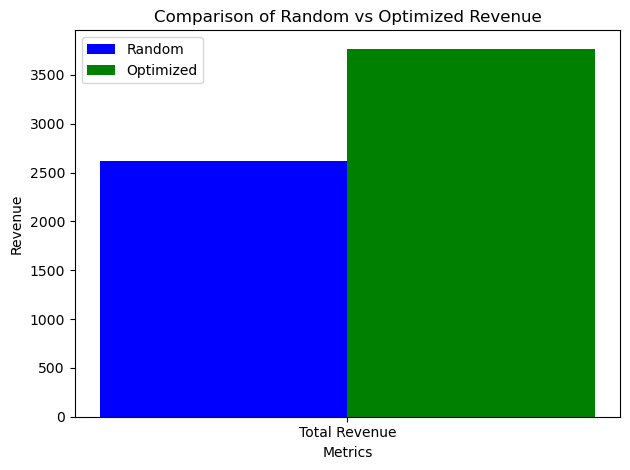

In [171]:
import matplotlib.pyplot as plt

# Function to calculate total revenue for random assignment
def calculate_random_total_revenue(revenue_matrix, num_passengers, num_drivers):
    random_revenue = 0
    # Random assignment (choose random driver for each passenger)
    for p in range(num_passengers):
        random_driver = np.random.randint(0, num_drivers)
        random_revenue += revenue_matrix[p, random_driver]
    return random_revenue

# Calculate total revenue for random assignment
random_revenue = calculate_random_total_revenue(revenue_matrix, num_passengers, num_drivers)

# Calculate total revenue for optimized assignment
optimized_revenue = np.sum([revenue_matrix[p, d] for p in range(num_passengers) for d in range(num_drivers) if tij.value[p, d] > 0.5])

# Plot bar graph for revenue comparison
labels = ['Total Revenue']
random_values = [random_revenue]
optimized_values = [optimized_revenue]

x = np.arange(len(labels))  # Label positions

fig, ax = plt.subplots()
bar_width = 0.35

# Plot bars for random and optimized revenue
ax.bar(x - bar_width/2, random_values, bar_width, label='Random', color='b')
ax.bar(x + bar_width/2, optimized_values, bar_width, label='Optimized', color='g')

# Labeling the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Revenue')
ax.set_title('Comparison of Random vs Optimized Revenue')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


### Plots to check the optimization

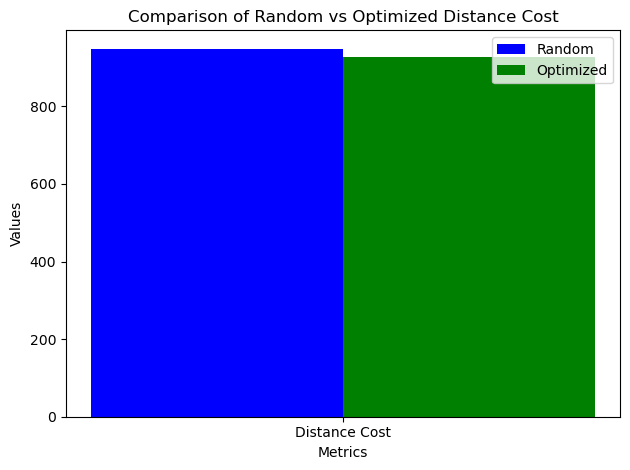

In [174]:
import matplotlib.pyplot as plt

# Function to calculate the total distance cost for random assignment
def calculate_random_distance_cost(distance_matrix, num_passengers, num_drivers):
    random_distance_cost = 0
    # Random assignment (choose random driver for each passenger)
    for p in range(num_passengers):
        random_driver = np.random.randint(0, num_drivers)
        random_distance_cost += distance_matrix[p, random_driver]
    return random_distance_cost

# Calculate random total distance cost for random assignment
random_distance_cost = calculate_random_distance_cost(distance_matrix, num_passengers, num_drivers)

# Calculate the optimized total distance cost
optimized_distance_cost = np.sum([distance_matrix[p, d] for p in range(num_passengers) for d in range(num_drivers) if tij.value[p, d] > 0.5])

# Plot bar graph for optimized distance cost comparison
labels = ['Distance Cost']
random_values = [random_distance_cost]
optimized_values = [optimized_distance_cost]

x = np.arange(len(labels))  # Label positions

fig, ax = plt.subplots()
bar_width = 0.35

# Plot bars for random and optimized distance costs
ax.bar(x - bar_width/2, random_values, bar_width, label='Random', color='b')
ax.bar(x + bar_width/2, optimized_values, bar_width, label='Optimized', color='g')

# Labeling the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Random vs Optimized Distance Cost')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
